In [45]:
# some default settings
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [46]:
import numpy as np
import sys
import regionmask
import pylab as plt
import cartopy.crs as ccrs      # map projections
import xarray as xr             # major tool to work with NetCDF data!
import netCDF4 as nc4
import pandas as pd

In [47]:
#Africa_extent = [-17, 51, -35, 38]
Africa_extent = [-17, 45, -35, 34] # a bit smaller than before
iyear = 2015
lat_res = 1. # latitudinal resolution, to compute grid area
lon_res = 1.

In [48]:
# read in a NetCDF file
fname = '/Users/mehliyarsadiq/Desktop/africa_fluxes/L4_FLUXMAP_1x1_UoE_ln_v1.0.nc'
#fname = '/Users/ppalmer/Desktop/1x1files/L4_FLUXMAP_1x1_UoE_ln_v1.0.nc'
ds    = xr.open_dataset(fname)
drin  = ds['land'] # dataarray
latin = ds['lat']  # dataarray
lonin = ds['lon']  # dataarray
date  = ds['start_date']

In [49]:
# get subset of ds that belongs to 2015 or a specified year (iyear)
nmonths = len(ds.n_months)
years = []
for ii in np.arange(nmonths): years.append(np.squeeze(date.data[ii][0]))
years = np.array(years)
ind = np.where(years == iyear)
ind = ind[0][:]
# subset of dataset, 12 months of global fluxes
dr_iyear = ds.land[ind,:,:] # use this to do calculations, dim = [12,180,360]
dr_iyear # unit: kgC/m2/s

<xarray.DataArray 'land' (n_months: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * n_months  (n_months) int32 4 5 6 7 8 9 10 11 12 13 14 15
  * lon       (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    _fill_value:  -999.0
    units:        kgC/m2/s

In [50]:
mask_countries = regionmask.defined_regions.natural_earth.countries_110.mask(dr_iyear)


In [51]:
# find the indices of countries within Africa extent, roughly
mask_smaller = mask_countries.sel(lat = slice(Africa_extent[2],Africa_extent[3]), lon = slice(Africa_extent[0],Africa_extent[1]))
africa_countries = np.unique(mask_smaller.values) # unique values

nan_array = np.isnan(africa_countries) # get rid of nan
not_nan_array = ~ nan_array
ind_rough = africa_countries[not_nan_array]

len(ind_rough)

58

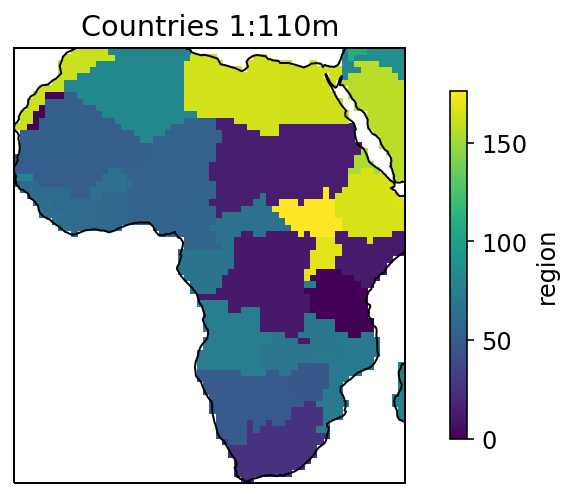

In [52]:
#--------------------------
# Plot environment
#--------------------------
proj=ccrs.PlateCarree()
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection=proj)

#--------------------------
# Plot mask over Africa
#--------------------------

mask_countries.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8,})

ax.set_title("Countries 1:110m")
ax.coastlines()
ax.set_extent(Africa_extent, crs=ccrs.PlateCarree());
# some non African countries will be included

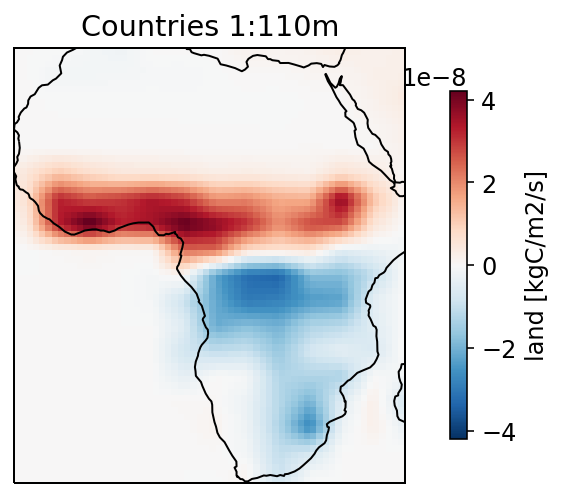

In [53]:
#--------------------------
# Plot CO2 field over Africa
#--------------------------
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection=proj)
# plot first month of the year
dr_iyear[0,:,:].plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})

ax.set_title("Countries 1:110m")
ax.coastlines()
ax.set_extent(Africa_extent, crs=ccrs.PlateCarree());

In [54]:
# Function
# Approximate the area of a spatial grid square from the latitudes and longitudes of the diagonal vertices
def area_latlon(lat1, lon1, lat2, lon2):
    """
    This function calculates the area (in km^2) of a spatial grid square, given the latitudes and longitudes of the two diagonal vertices of the grid square.
    lat/lon is in angle; lat: [-90:90]; lon:[-180:180].
    lat1/lon1 and lat2/lon2 are thus the diagonal vertices of the square grid.
    """
    lat1 = lat1/180*np.pi
    lat2 = lat2/180*np.pi
    lon1 = lon1/180*np.pi
    lon2 = lon2/180*np.pi
    A = np.absolute(6371.009**2*(np.sin(lat2)-np.sin(lat1))*(lon2-lon1))
    return A

In [55]:
daysinmonth = [31,28,31,30,31,30,31,\
               31,30,31,30,31,30,31]

for imonth in range(12):
    for ilat, lat in enumerate(dr_iyear.lat):
        area_tmp = area_latlon(lat1 = lat, 
                           lon1 = dr_iyear.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = dr_iyear.lon[10].values + lon_res) # km^2
        dr_iyear[imonth,ilat,:] = dr_iyear[imonth,ilat,:] * area_tmp *3600*24*daysinmonth[imonth] *1e6 # unit: kgCO2/month. 
    # unit conversion: kgC/m2/s to kgC/month


In [56]:
# annual total, PgC/year
dr_annual = dr_iyear.sum(dim = 'n_months') * 1e-9 # unit: kgC/month to PgC/year

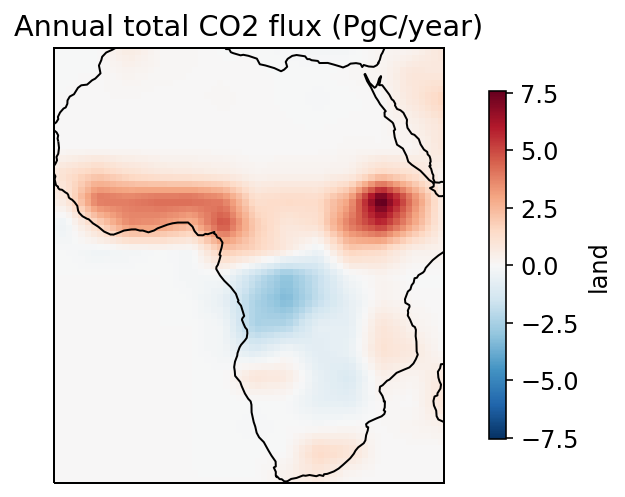

In [57]:
#--------------------------
# Annual total CO2 over Africa
#--------------------------
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection=proj)

dr_annual.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})

ax.set_title("Annual total CO2 flux (PgC/year)")
ax.coastlines()
ax.set_extent(Africa_extent, crs=ccrs.PlateCarree());

In [60]:
#--------------------------
# Use the mask to quantify flux estimates for individual countries
#--------------------------

# you can group over all integer values of the mask
# and compute mean (or total) values for each country
co2fluxbudget = dr_annual.groupby(mask_countries).sum('stacked_lat_lon')
country_names = regionmask.defined_regions.natural_earth.countries_110[co2fluxbudget.region.values].names

co2fluxbudget.coords['names'] = ('region', country_names)

co2flux_subset = co2fluxbudget.sel(region = ind_rough) # get subset of the results
co2flux_subset # 58 countries

<xarray.DataArray 'land' (region: 58)>
array([ 1.6014076e+01,  2.0831509e-01, -1.9267059e+02,  1.1816230e+01,
        4.2864449e+01,  1.2165023e+02,  4.7977165e+01,  4.8218433e+01,
        2.2107918e+00, -2.5046974e+01, -1.7720314e+01,  1.4612326e+01,
        1.5209682e+01,  8.2960945e+01,  1.7784328e+01,  3.9322590e+01,
        3.2458698e+01,  2.2290076e+02,  1.0321154e+02,  1.8650246e+01,
        7.6649071e+01,  8.9976654e+01,  6.0636135e+01,  3.1533780e+00,
        1.4945517e+01,  1.2295910e+01,  4.5153824e+01,  6.3006577e+01,
       -1.4866110e+01,  6.0376749e+00,  3.3943043e+00, -3.2823887e+01,
        7.9096193e+00,  2.5121288e+01,  1.6980305e-01, -1.2322450e+02,
       -8.2759202e-01,  1.9753644e-01,  1.6580479e-01,  3.2032509e+01,
        3.2932940e+00,  1.8563080e-01,  1.4847442e+01,  2.7328327e+00,
        3.2986004e+01,  7.6692538e+00,  7.5401669e+00,  1.2883527e+01,
        1.3697958e+02,  1.0451533e+01,  7.1891987e-01, -1.3779956e-01,
        3.0543787e+02,  2.8235462e+00,  6.0864015e+00,  3.0756054e+01,
       -3.9991575e-01,  1.8596895e+02], dtype=float32)
Coordinates:
  * region   (region) float64 1.0 2.0 11.0 12.0 13.0 ... 167.0 168.0 169.0 176.0
    names    (region) <U24 'Tanzania' 'W. Sahara' ... 'Rwanda' 'S. Sudan'

In [61]:
co2flux_subset.names

<xarray.DataArray 'names' (region: 58)>
array(['Tanzania', 'W. Sahara', 'Dem. Rep. Congo', 'Somalia', 'Kenya',
       'Sudan', 'Chad', 'South Africa', 'Lesotho', 'Zimbabwe', 'Botswana',
       'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger',
       'Nigeria', 'Cameroon', 'Togo', 'Ghana', "CÃ´te d'Ivoire", 'Guinea',
       'Guinea-Bissau', 'Liberia', 'Sierra Leone', 'Burkina Faso',
       'Central African Rep.', 'Congo', 'Gabon', 'Eq. Guinea', 'Zambia',
       'Malawi', 'Mozambique', 'eSwatini', 'Angola', 'Burundi', 'Israel',
       'Lebanon', 'Madagascar', 'Gambia', 'Tunisia', 'Algeria', 'Jordan',
       'Iraq', 'Syria', 'Eritrea', 'Yemen', 'Saudi Arabia', 'Morocco',
       'Egypt', 'Libya', 'Ethiopia', 'Djibouti', 'Somaliland', 'Uganda',
       'Rwanda', 'S. Sudan'], dtype='<U24')
Coordinates:
  * region   (region) float64 1.0 2.0 11.0 12.0 13.0 ... 167.0 168.0 169.0 176.0
    names    (region) <U24 'Tanzania' 'W. Sahara' ... 'Rwanda' 'S. Sudan'

In [62]:
d = {'country': co2flux_subset.names, 'co2': co2flux_subset.values}
df = pd.DataFrame(data=d)
df_sorted = df.sort_values(by=['country'])

In [63]:
not_african_countries = ['Iraq', 'Israel', 'Jordan', 'Lebanon', 'Saudi Arabia', 'Syria', 'Yemen']

for j in range(len(not_african_countries)):
    # Get names of indexes
    indexNames = df_sorted[df_sorted['country'] == not_african_countries[j]].index
    # Delete these row indexes from dataFrame
    df_sorted.drop(indexNames, inplace=True)

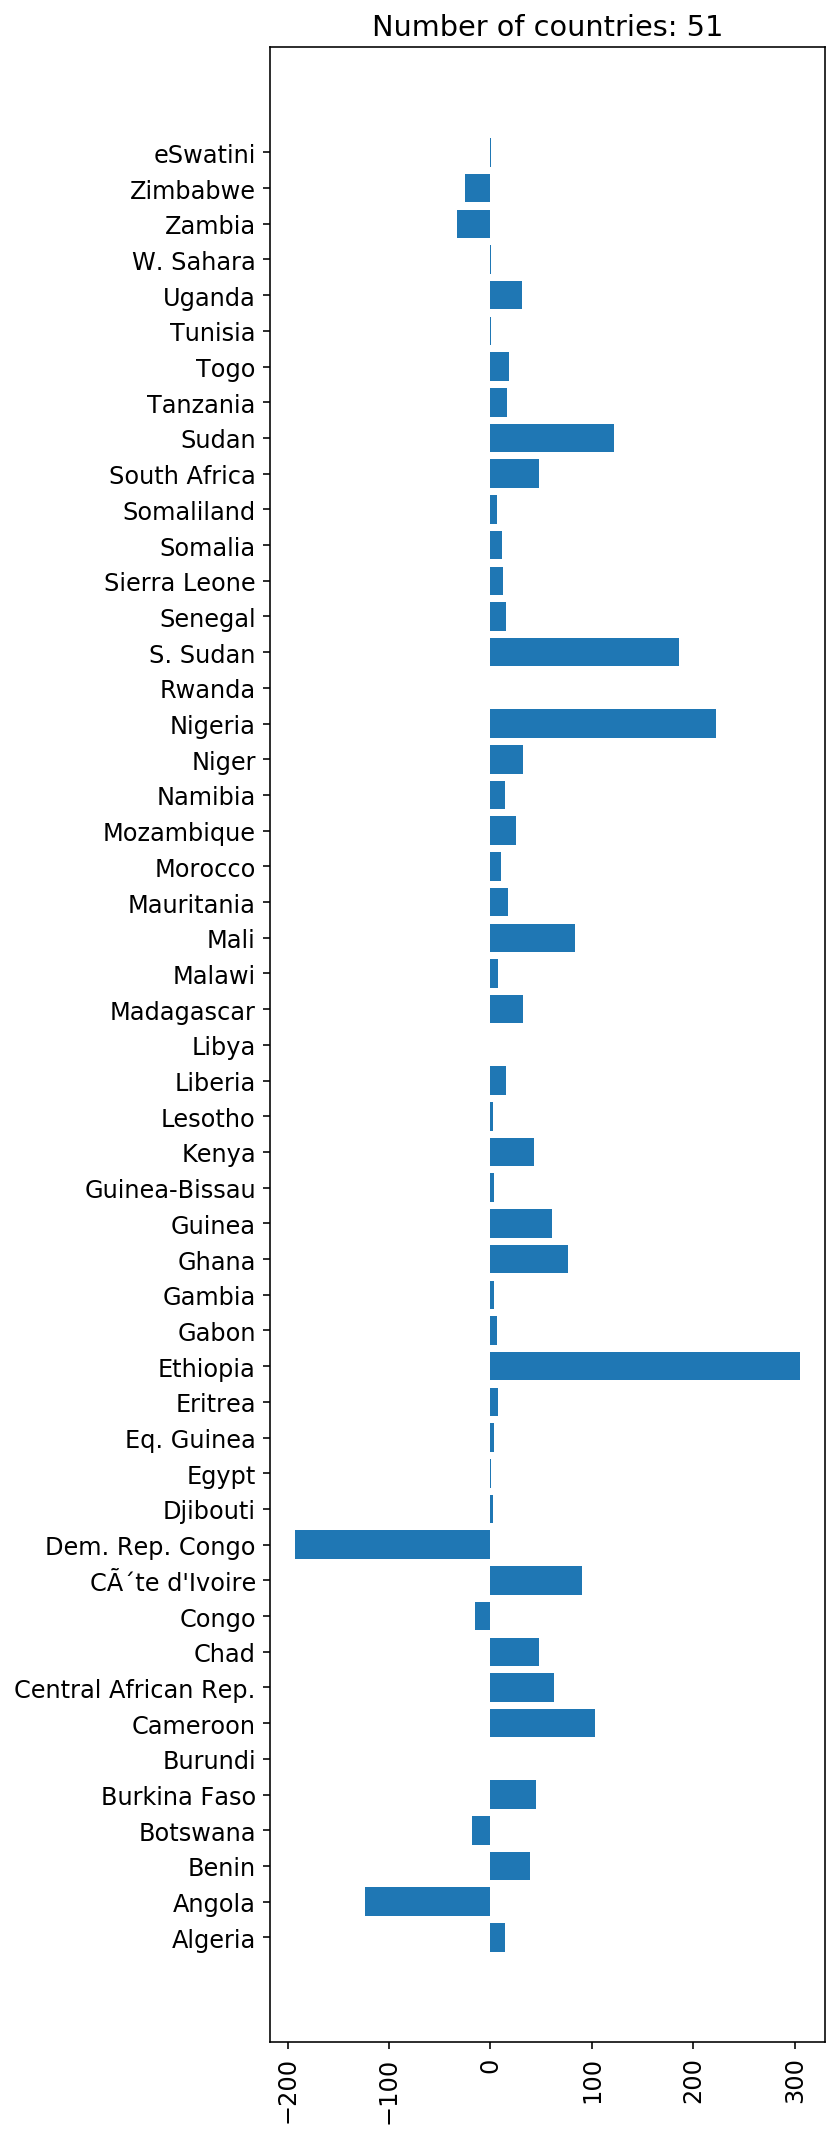

In [64]:
# 
fig = plt.figure(figsize=[6, 15])
plt.barh(df_sorted.country, df_sorted.co2)
plt.title('Number of countries: ' + str(len(df_sorted)))
plt.xticks(rotation=90)

fig.tight_layout()


In [65]:
print('Total annual CO2 over African countries: ' + str(sum(df_sorted.co2)))

Total annual CO2 over African countries: 1438.9451811164618


In [67]:
df_sorted.to_csv('/Users/mehliyarsadiq/Desktop/africa_fluxes/fluxes.txt', header=None, index=None, sep=' ', mode='a')
